# Análisis KPIs Propuestos 
Primero que nada, trabajaremos la data cruda del mismo modo que lo hicimos en el EDA de google, para luego poder analizarla.  
No comentamos, ya que todo este mismo trabajo se realizo en el archivo antes mencionado.

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import seaborn as sns
from collections import Counter
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [51]:
reviews = pd.read_parquet("Bases_de_datos/Google Maps/reviews-estados/data/review-Florida.parquet")

A partir del archivo de base de locales, traemos la categoría para así poder trabajar solamente con los locales de las categorías en las que estamos interesados.

In [52]:
sitios = pd.read_parquet("Bases_de_datos/data_filtrada.parquet")

In [53]:
reviews = reviews.merge(sitios[['gmap_id', 'category']], on='gmap_id', how='left')

In [54]:
keywords = ["restaurant", "grill"]
reviews = reviews[reviews['category'].fillna('').str.contains('|'.join(keywords), case=False)]

In [55]:
reviews['resp'] = reviews['resp'].apply(lambda x: x.get('text') if isinstance(x, dict) else x)

In [56]:
reviews['text'] = reviews['text'].str.replace(')', '').str.replace('(', '').str.replace('&', '').str.replace('.', '')
reviews['resp'] = reviews['resp'].str.replace(')', '').str.replace('(', '').str.replace('&', '').str.replace('.', '')

In [57]:
# Suponiendo que 'florida' es tu DataFrame
reviews['pics'] = reviews['pics'].apply(lambda x: 1 if isinstance(x, list) and len(x) > 0 else x)

In [58]:
sitios = sitios[sitios['state'] == 'Florida']

## Análisis Categorías
Como podemos ver a continuación, analizando las categorías vemos que existen 1517 categorías únicas. Yendo al detalle y análisis, vemos que hay muchos registros que tienen en un mismo registro varias categorías, (por ejemplo restaurant, Italian restaurant).  
Esto es lo que hace que tengamos tantas categorias. Para lograr generalizar esto y poder realizar un mejor análisis a futuro, vamos a realizar lo siguiente:   
    - Tomar como categorías, las 11 categorías únicas que más se repiten ordenadas de mayor cantidad de veces a menor: ["Restaurant", "Mexican restaurant","Pizza restaurant", "American restaurant", "Bar & grill", "Seafood restaurant", "Italian restaurant", "Barbecue restaurant", "Fast food restaurant", "Cuban restaurant","Chinese restaurant"]  
    - Estos registros dejarlos así, para los restantes mediante un ciclo for revisaremos si tienen alguna categoría de las que se encuentran en el top 11, y dejaremos esa como categoría  
    - Priorizamos aquellas categorías que dan mayor especificidad. Básicamente, si dice restaurant y Mexican, quedará como Mexican.  
    - Con este análisis pasamos de tener 1517 categorías a 10 y de 467000 registros reducimos a 388000.


In [59]:
print('Tenemos originalmente', len(reviews),'registros con ', len(reviews['category'].unique()),' categorías únicas:',reviews['category'].unique())

Tenemos originalmente 467440 registros con  1517  categorías únicas: ['Modern French restaurant, Restaurant' 'Restaurant' 'American restaurant'
 ... 'Breakfast restaurant, American restaurant, Brunch restaurant, Diner'
 'Video arcade, Event venue, Restaurant, Sports bar'
 'American restaurant, Bar & grill, Restaurant, Southern restaurant (US)']


In [60]:
reviews.groupby(['category'])['category'].count().sort_values(ascending = False).head(30)

category
Restaurant                                                                                                                                   24409
Mexican restaurant                                                                                                                           12373
Seafood restaurant                                                                                                                           10850
American restaurant                                                                                                                           9324
Barbecue restaurant                                                                                                                           7164
Seafood restaurant, Restaurant                                                                                                                6982
Italian restaurant                                                                                           

In [61]:
categories_def = ["Mexican restaurant","Pizza restaurant", "American restaurant", "Bar & grill", "Seafood restaurant", "Italian restaurant", "Barbecue restaurant", "Fast food restaurant", "Cuban restaurant","Chinese restaurant" ]
#en la lista de categorias definitivas no incluimos restaurant por un tema de
reviews_final = reviews.copy()
def replace_categories(categories):
    categories = categories.split(', ')  # Dividir las categorías separadas por comas en una lista
    last_valid_category = ''
    for category in categories:
        if category in categories_def:
            last_valid_category = category
    if last_valid_category == '':
        for category in categories:
            if category == 'Restaurant':
                last_valid_category = 'Restaurant'

    return last_valid_category

# Aplicar la función a la columna 'Restaurant' del DataFrame
reviews_final['category'] = reviews_final['category'].apply(replace_categories)

In [62]:
categories_def.append('Restaurant')
reviews_final = reviews_final[reviews_final['category'].isin(categories_def)]

In [63]:
print('Nos quedamos con', len(reviews_final),'registros con ', len(reviews_final['category'].unique()),' categorías únicas:',reviews_final['category'].unique())

Nos quedamos con 394593 registros con  11  categorías únicas: ['Restaurant' 'American restaurant' 'Pizza restaurant'
 'Seafood restaurant' 'Cuban restaurant' 'Italian restaurant'
 'Chinese restaurant' 'Fast food restaurant' 'Bar & grill'
 'Mexican restaurant' 'Barbecue restaurant']


In [64]:
reviews_final.groupby(['category'])['category'].count().sort_values(ascending = False).head(23)

category
Restaurant              94065
Seafood restaurant      79189
American restaurant     67956
Mexican restaurant      29091
Italian restaurant      27132
Pizza restaurant        26580
Bar & grill             21006
Barbecue restaurant     19442
Cuban restaurant        14405
Chinese restaurant      10792
Fast food restaurant     4935
Name: category, dtype: int64

In [65]:
reviews.tail()

,user_id,name,time,rating,text,pics,resp,gmap_id,state,year,category
2844769,107168603440985823672,Nicole Agostini,2016-08-07 15:59:46.994,4,None,None,None,0x88e77a7ca8450fbd:0xfb0b4a6a6f39353a,Florida,2016,"American restaurant, Bar & grill, Restaurant, ..."
2844770,108914971201741263081,mariella vernazzaro,2018-10-14 08:32:50.275,3,None,None,None,0x88e77a7ca8450fbd:0xfb0b4a6a6f39353a,Florida,2018,"American restaurant, Bar & grill, Restaurant, ..."
2844771,117220186391575033294,bobbifette,2019-04-05 00:08:18.227,5,None,None,None,0x88e77a7ca8450fbd:0xfb0b4a6a6f39353a,Florida,2019,"American restaurant, Bar & grill, Restaurant, ..."
2844772,118338591478240420713,Gates McClain,2020-02-15 20:39:15.115,5,None,None,None,0x88e77a7ca8450fbd:0xfb0b4a6a6f39353a,Florida,2020,"American restaurant, Bar & grill, Restaurant, ..."
2844773,109659207944175514556,Kent Early,2018-09-10 11:20:35.073,5,None,None,None,0x88e77a7ca8450fbd:0xfb0b4a6a6f39353a,Florida,2018,"American restaurant, Bar & grill, Restaurant, ..."


In [66]:
reviews_final.tail()

,user_id,name,time,rating,text,pics,resp,gmap_id,state,year,category
2844769,107168603440985823672,Nicole Agostini,2016-08-07 15:59:46.994,4,None,None,None,0x88e77a7ca8450fbd:0xfb0b4a6a6f39353a,Florida,2016,Bar & grill
2844770,108914971201741263081,mariella vernazzaro,2018-10-14 08:32:50.275,3,None,None,None,0x88e77a7ca8450fbd:0xfb0b4a6a6f39353a,Florida,2018,Bar & grill
2844771,117220186391575033294,bobbifette,2019-04-05 00:08:18.227,5,None,None,None,0x88e77a7ca8450fbd:0xfb0b4a6a6f39353a,Florida,2019,Bar & grill
2844772,118338591478240420713,Gates McClain,2020-02-15 20:39:15.115,5,None,None,None,0x88e77a7ca8450fbd:0xfb0b4a6a6f39353a,Florida,2020,Bar & grill
2844773,109659207944175514556,Kent Early,2018-09-10 11:20:35.073,5,None,None,None,0x88e77a7ca8450fbd:0xfb0b4a6a6f39353a,Florida,2018,Bar & grill


## Análisis KPIs
A continuación, vamos a analizar los valores históricos de los distintos kpis propuestos para la base obtenida de google para comenzar a comprender que valores objetivos podríamos considerar para evaluar la performance del negocio a futuro.

In [67]:
reviews_final['month'] = reviews_final['time'].dt.month

### KPI 1 - Valoración media de las reseñas
Es un indicador sobre el valor medio de las reseñas que van de 1 a 5. Su importancia radica en que la experiencia de los consumidores es clave en la decisión de consumo de otros consumidores.


Primero que nada, analizaremos la media total de todas las evaluaciones y como fue evolucionando la media anual de todas las evaluaciones de todos los registros.

In [68]:
reviews_final['rating'].mean()

4.402374091785713

<Axes: xlabel='year', ylabel='rating'>

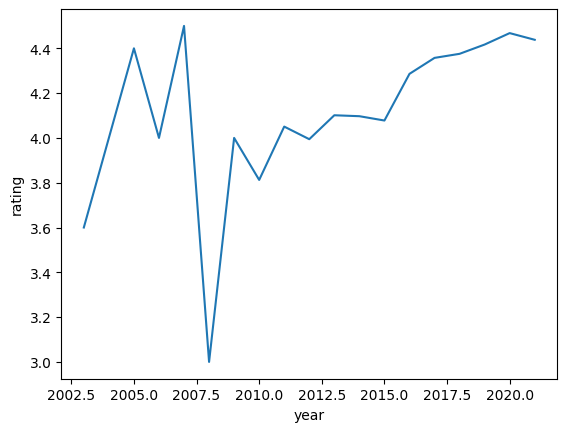

In [69]:
sns.lineplot(x='year',y='rating', data=reviews_final,ci=None)

Podemos ver como fue aumentando la media de las ratings año a año, a pesar de que hubo una caida brusca durante los años 2008 y 2009.  

A continuación vamos a revisar la media de ratings promedio de los restaurants (quitandole el peso que tienen la cantidad de clientes que hayan colocado ratings a cada restaurant). Para esto, vamos revisarlo desde la base de dato sitios que ya tiene el rating medio de cada restaurant.

In [70]:
sitios['category'] = sitios['category'].apply(replace_categories)
sitios = sitios[sitios['category'] != '']
sitios.head(4)

,name,address,gmap_id,latitude,longitude,category,avg_rating,num_of_reviews,MISC,state
5,Cape Seafood Shack,"Cape Seafood Shack, 603 Del Prado Blvd S, Cape...",0x88db4147b1d9e6f3:0x943dbd10a92ba1b1,26.641377,-81.940545,Restaurant,5.0,1,{'Accessibility': ['Wheelchair accessible entr...,Florida
32,Hot Box,"Hot Box, 1-99 Kinkaid St, Pensacola, FL 32507",0x8890b9241e704667:0x3a1e565c17c00993,30.391411,-87.267220,Restaurant,4.2,5,"{'Accessibility': None, 'Activities': None, 'A...",Florida
45,Gormley's on the river | Modern cuisine in his...,Gormley's on the river | Modern cuisine in his...,0x8894b5a7a7909725:0xe4687299fd288188,29.726949,-84.981535,Restaurant,4.3,17,"{'Accessibility': None, 'Activities': None, 'A...",Florida
49,Shell,"Shell, 15877 E, FL-40, Silver Springs, FL 34488",0x88e635378f43352f:0xa1b53c63436fa428,29.183272,-81.889965,Restaurant,1.8,5,{'Accessibility': ['Wheelchair accessible entr...,Florida


In [71]:
sitios['avg_rating'].mean()

4.25229742112842

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'Restaurant'),
  Text(1, 0, 'Mexican restaurant'),
  Text(2, 0, 'American restaurant'),
  Text(3, 0, 'Pizza restaurant'),
  Text(4, 0, 'Seafood restaurant'),
  Text(5, 0, 'Cuban restaurant'),
  Text(6, 0, 'Chinese restaurant'),
  Text(7, 0, 'Italian restaurant'),
  Text(8, 0, 'Fast food restaurant'),
  Text(9, 0, 'Bar & grill'),
  Text(10, 0, 'Barbecue restaurant')])

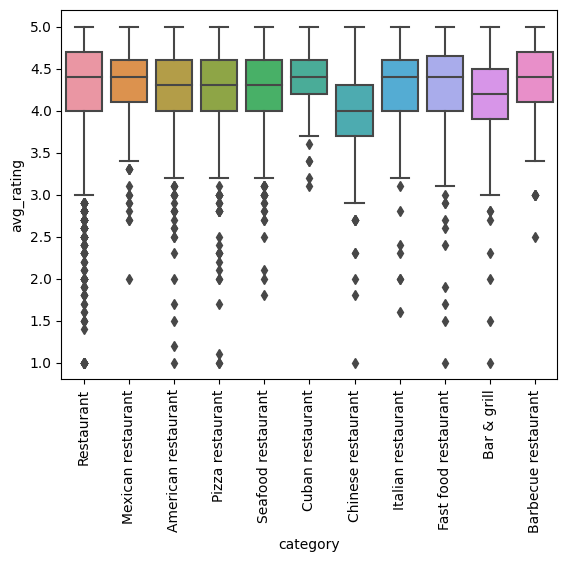

In [72]:
sns.boxplot(x='category',y='avg_rating',data=sitios)
plt.xticks(rotation=90)

Podemos ver una media levemente mayor en los restaurants de comida típica de algún país y de barbecue.  
Teniendo en cuenta esto, la evolución analizada anteriormente y el target al que apunta a nuestro cliente el objetivo de este kpi será tener una media de reseñas con un rating mayo a 4.3.

### KPI 2 -Cantidad de reseñas del local en el último año

Text(0.5, 1.0, 'Avg_rating vs num_of_reviews (Histórico)')

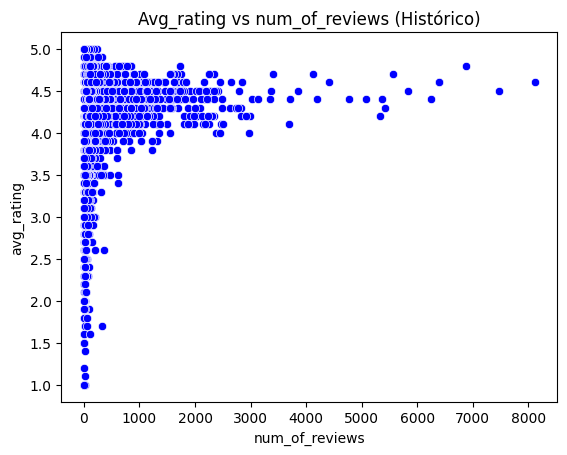

In [73]:
sns.scatterplot(x='num_of_reviews', y='avg_rating', data=sitios, marker='o', color='b')
plt.title('Avg_rating vs num_of_reviews (Histórico)')

Cómo podemos ver a partir del gráfico anterior, existe una relación entre la cantidad de clientes que dejan ratings y los ratings promedio. Probablemente tenga que ver con que los altos promedios atraen más clientes

Text(0.5, 1.0, 'Avg_rating vs num_of_reviews (2020)')

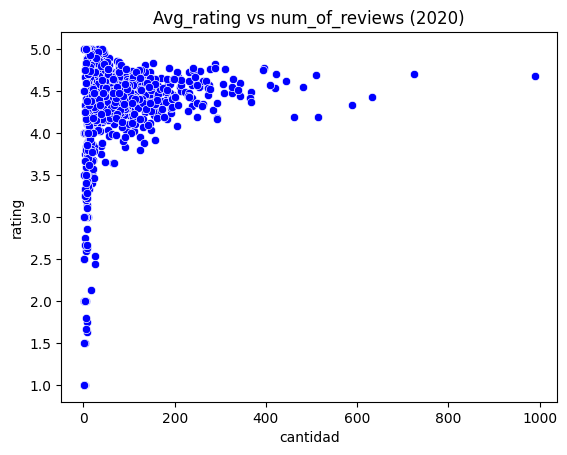

In [74]:
aux = reviews_final[reviews_final['year']==2020].groupby('gmap_id').agg({'rating': 'mean', 'user_id': 'count'}).reset_index()
aux.rename(columns={'user_id': 'cantidad'}, inplace=True)
sns.scatterplot(x='cantidad', y='rating', data=aux, marker='o', color='b')
plt.title('Avg_rating vs num_of_reviews (2020)')

In [75]:
print('La media de cantidad reseñas de los restaurants con más 4 como promedio de ratings es de', aux[aux['rating']>4]['cantidad'].mean())

La media de cantidad reseñas de los restaurants con más 4 como promedio de ratings es de 46.3037088873338


Por otro lado, analizando durante el período 2020 y teniendo en cuenta que la media de cantidad de reseñas en el 2020 para restaurants con puntuacion es de 47, apuntaremos como objetivo recibir un mínimo de 50 reseñas anuales. Este objetivo a medida que el negocio crezca se podría ir revisando

### KPI 3 - Customer Satisfaction Score (CSAT)
Es un indicador que se utiliza para calcular el porcentaje de clientes satisfechos con tu marca y con la experiencia que brinda tu empresa en diferentes momentos. Se consideran como satisfechos aquellas puntuaciones con 4 y 5 estrellas


In [76]:

reviews_final.reset_index(drop=True,inplace=True)
def calcular_nueva_columna(valor):
    if valor >= 4:
        return 1
    else:
        return 0

# Aplicar la función a la columna 'valor' para crear 'nueva_columna'
reviews_final['Rating_Satif'] = reviews_final['rating'].apply(calcular_nueva_columna)



In [77]:
aux2 = reviews_final[reviews_final['year']==2020].groupby('gmap_id').agg({'Rating_Satif': 'sum', 'name': 'count'}).reset_index()
aux2.rename(columns={'name': 'cantidad'}, inplace=True)
aux2['CSAT'] = 100*aux2['Rating_Satif']/aux2['cantidad']
print('Media de CSAT de', aux2['CSAT'].mean(),'y mediana de ',aux2['CSAT'].median())

Media de CSAT de 84.97483599412371 y mediana de  90.0


<Axes: xlabel='CSAT', ylabel='Count'>

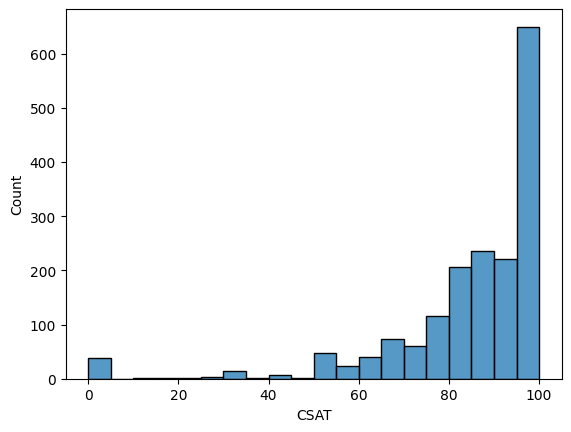

In [78]:
sns.histplot(x='CSAT',data=aux2, bins = 20)

Analizando la media, mediana y distribución de los CSAT de los restaurants durante el año 2020, proponemos como objetivo para el KPI un valor mínimo del 90 %

### KPI 4 - Porcentaje de reseñas negativas
Es un indicador que se utiliza para calcular el porcentaje de clientes no satisfechos con tu marca y con la experiencia que brinda tu empresa en diferentes momentos. Se consideran como no satisfechos aquellas puntuaciones con 1 y 2 estrellas


In [79]:
def res_neg(valor):
    if valor <=2:
        return 1
    else:
        return 0
reviews_final['res_neg'] = reviews_final['rating'].apply(res_neg)
aux3 = reviews_final[reviews_final['year']==2020].groupby('gmap_id').agg({'res_neg': 'sum', 'name': 'count'}).reset_index()
aux3.rename(columns={'name': 'cantidad'}, inplace=True)
aux3['Rneg'] = 100*aux3['res_neg']/aux3['cantidad']
print('Media de Rneg de', aux3['Rneg'].mean(),'y mediana de ',aux3['Rneg'].median())

Media de Rneg de 8.639368234308632 y mediana de  2.955736750145603


<Axes: xlabel='Rneg', ylabel='Count'>

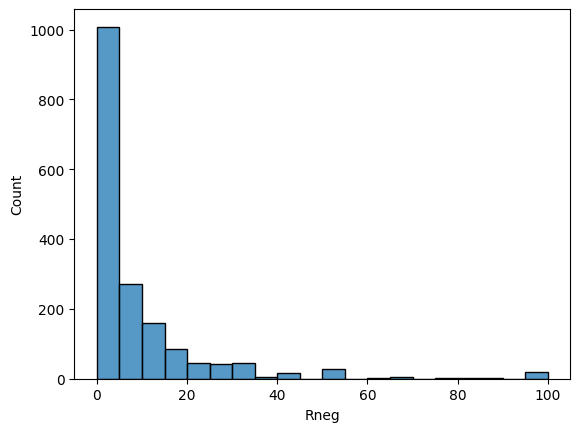

In [80]:
sns.histplot(x='Rneg',data=aux3, bins = 20)

Analizando la media, mediana y distribución de los Rneg de los restaurants durante el año 2020, proponemos como objetivo para el KPI un valor máximo del 5 %

### KPI 5 - Tasa de Repetición de clientes

In [81]:
sitios[['gmap_id','num_of_reviews']].sort_values(by='num_of_reviews',ascending = False)

,gmap_id,num_of_reviews
98289,0x88e4279668c1a2f1:0x8c1cd12f09764aeb,8116
93598,0x8890a84997a3ca01:0xb5c7b6fa2bbf6d9e,7471
91920,0x88d9ac593d9be06d:0x7571ded5edc4f9ba,6882
97071,0x8890c63dae1c2e73:0x1482c825e7f0d0ae,6398
91050,0x88d9b4f10e788681:0x7a7c53c1c75a3ceb,6388
...,...,...
107341,0x88e7d2f0016067db:0x2e9eecac2b98722c,1
107265,0x88d8d9d297e783a1:0x2abe0398ce143b0f,1
36808,0x88949bd4372407c7:0x4fc43c668972d06,1
106699,0x88dd875e207ffa81:0xfebc2661a0f354a3,1


reviews_final[reviews_final['gmap_id']=='0x88e4279668c1a2f1:0x8c1cd12f09764aeb']

In [82]:
reviews_final[reviews_final['gmap_id']=='0x88e4279668c1a2f1:0x8c1cd12f09764aeb']['user_id']

362307    107678765385838856248
362308    105448452003051661659
362309    103456250441241108592
362310    112862527410693501595
362311    104699567269984599763
                  ...          
367216    100824042969959704136
367217    118305769859612739413
367218    104431457304026477902
367219    108093635760378272633
367220    100070244802651303881
Name: user_id, Length: 4914, dtype: object

In [83]:
reviews_final[(reviews_final['gmap_id']=='0x88e4279668c1a2f1:0x8c1cd12f09764aeb')& (reviews_final['user_id'] == '110081410709194030135')]

,user_id,name,time,rating,text,pics,resp,gmap_id,state,year,category,month,Rating_Satif,res_neg
364334,110081410709194030135,John Monteiro,2017-07-26 22:12:09.326,4,Very cool New Orleans style spot Awesome decor...,None,None,0x88e4279668c1a2f1:0x8c1cd12f09764aeb,Florida,2017,Seafood restaurant,7,1,0
364345,110081410709194030135,John Monteiro,2017-07-26 22:12:09.326,4,Very cool New Orleans style spot Awesome decor...,None,None,0x88e4279668c1a2f1:0x8c1cd12f09764aeb,Florida,2017,Seafood restaurant,7,1,0
364424,110081410709194030135,John Monteiro,2017-07-26 22:12:09.326,4,Very cool New Orleans style spot Awesome decor...,None,None,0x88e4279668c1a2f1:0x8c1cd12f09764aeb,Florida,2017,Seafood restaurant,7,1,0


Analizando, vemos que este KPI no nos servirá ya que no existen casos de clientes con más de 1 reseña. Probablemente sea porque no está permitido subir más de una reseña o porque de la API se descarga solo la última reseña

### KPI 6 - Porcentaje de respuestas a reseñas negativas
Es un indicador que se utiliza para calcular el porcentaje de respuestas que se dieron a reseñas negativas. Si bien 


In [84]:
def notnones(valor):
    if pd.isna(valor):
        return 0
    else:
        return 1
reviews_final['Con_resp'] = reviews_final['resp'].apply(notnones)


aux4 = reviews_final[(reviews_final['year']==2020)&(reviews_final['res_neg']==1)].groupby('gmap_id').agg({'Con_resp': 'sum', 'name': 'count'}).reset_index()


aux4.rename(columns={'name': 'cantidad'}, inplace=True)
aux4['%Resp'] = 100*aux4['Con_resp']/aux4['cantidad']
print('Media de Rneg de', aux4['%Resp'].mean(),'y mediana de ',aux4['%Resp'].median())


Media de Rneg de 21.56523663914435 y mediana de  0.0


In [85]:
aux4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gmap_id   940 non-null    object 
 1   Con_resp  940 non-null    int64  
 2   cantidad  940 non-null    int64  
 3   %Resp     940 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 29.5+ KB
